# TRACER+ Visualization

This program will walk through how to get data for NEXRAD radar, ARM CSPR radar, ARM soundings, and ACARs soundings. 

## Imports

In [1]:
import act
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.axis import Axis
from matplotlib.patches import ConnectionPatch
%matplotlib inline
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy import plots
from metpy.plots import Hodograph, SkewT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4
import numpy as np
import pandas as pd
from PIL import Image
import pyart
from pyart.config import get_metadata
from pyart.graph import RadarMapDisplayBasemap
import pymeteo
from pymeteo.data import acars
from pymeteo.data.acars import getAirportByCode
from pymeteo import dynamics, thermo
import tempfile
import time
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\mpl_toolkits\basemap\__init__.py:33: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _matplotlib_version = LooseVersion(_matplotlib_version)
C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\mpl_toolkits\basemap\__init__.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mpl_required_version = LooseVersion('0.98')


## ACARS Upper Air Data

Here we are defining how to process the ACARS dataset once we retrieve it from the ACARS data base. 

In [2]:
def processDataSet(data):
    print("[+] Writing data into temporary file")
    tdata = tempfile.NamedTemporaryFile(delete=False)
    tdata.write(data.read())
    print("[-] Data written to {0}".format(tdata.name))
    print("[+] Opening data as NetCDF")
    d = data.read()
    with netCDF4.Dataset(tdata.name, mode='r') as nc:
        print("[-] Dataset open with")
#Setting each data type with the coordinating variable
        _z = nc["altitude"][:]
        _T = nc["temperature"][:]
        _qv = nc["waterVaporMR"][:]
        windSpeed = nc["windSpeed"][:]
        windDir = nc["windDir"][:]
        _lon = nc["longitude"][:]
        _lat = nc["latitude"][:]
        flag = nc["sounding_flag"][:]
        _airport = nc["sounding_airport_id"][:]
        time = nc["soundingSecs"][:]

        print ("[-] {0} Records".format(len(_z)))
        #conversions
        _p = thermo.p_from_pressure_altitude(_z, _T)
        _u, _v = dynamics.wind_deg_to_uv(windDir, windSpeed)
        _th = thermo.theta(_T, _p)

        # split the arrays when the flag changes sign
        splits = np.where(np.diff(time))[0]+1

        _z = np.split(_z, splits)
        _p = np.split(_p, splits)
        _th = np.split(_th, splits)
        _qv = np.split(_qv, splits)
        _u = np.split(_u, splits)
        _v = np.split(_v, splits)
        _T = np.split(_T, splits)
        _lat = np.split(_lat, splits)
        _lon = np.split(_lon, splits)
        _airport = np.split(_airport, splits)
        time = np.split(time, splits)
        flag = np.split(flag, splits)

        print("[-] Found {0} profiles".format(len(_z)))

        #re-shape data
        outputData = []
        for i in range(len(_z)):
            ts = time[i].compressed()
            if len(ts) == 0:
                # profiles without timestamps invalid?
                continue 

            profileDir = flag[i][0]
            if (profileDir == 0):
                continue

            z = _z[i].filled()
            p = _p[i].filled()
            th = _th[i].filled()
            qv = _qv[i].filled()
            u = _u[i].filled()
            v = _v[i].filled()
            T = _T[i].filled()
            lat = _lat[i].filled()
            lon = _lon[i].filled()
            airport = getAirportByCode(_airport[i][0])
            profileData = {
                "i": i,
                "n": len(z),
                "z": z if profileDir > 0 else z[::-1],
                "p": p if profileDir > 0 else p[::-1],
                "th": th if profileDir > 0 else th[::-1],
                "qv": qv if profileDir > 0 else qv[::-1],
                "u": u if profileDir > 0 else u[::-1],
                "v": v if profileDir > 0 else v[::-1],
                "T": T if profileDir > 0 else T[::-1],
                "lat": lat if profileDir > 0 else lat[::-1],
                "lon": lon if profileDir > 0 else lon[::-1],
                "airport": airport,
                "time": datetime.utcfromtimestamp(ts.mean()).strftime("%H%MZ"),
                "flag": profileDir
            }
            outputData.append(profileData)

        return outputData

Retrieving all the Datasets available from ACARs, the data only goes back 133 hours.

In [3]:
datasets = acars.getAvailableDatasets()
print(datasets)

[+] Fetching list of resources available
[-] Parsing list
['20220728_0300.gz', '20220728_0400.gz', '20220728_0500.gz', '20220728_0600.gz', '20220728_0700.gz', '20220728_0800.gz', '20220728_0900.gz', '20220728_1000.gz', '20220728_1100.gz', '20220728_1200.gz', '20220728_1300.gz', '20220728_1400.gz', '20220728_1500.gz', '20220728_1600.gz', '20220728_1700.gz', '20220728_1800.gz', '20220728_1900.gz', '20220728_2000.gz', '20220728_2100.gz', '20220728_2200.gz', '20220728_2300.gz', '20220729_0000.gz', '20220729_0100.gz', '20220729_0200.gz', '20220729_0300.gz', '20220729_0400.gz', '20220729_0500.gz', '20220729_0600.gz', '20220729_0700.gz', '20220729_0800.gz', '20220729_0900.gz', '20220729_1000.gz', '20220729_1100.gz', '20220729_1200.gz', '20220729_1300.gz', '20220729_1400.gz', '20220729_1500.gz', '20220729_1600.gz', '20220729_1700.gz', '20220729_1800.gz', '20220729_1900.gz', '20220729_2000.gz', '20220729_2100.gz', '20220729_2200.gz', '20220729_2300.gz', '20220730_0000.gz', '20220730_0100.gz', '

When retrieving a specific dataset, we change the number value to the amount of hours since the dataset. -2 is 2 hours before the current time. 

In [4]:
ds = acars.getDataSet(datasets[-2])

[+] Fetching dataset 20220802_1400.gz
[-] Decompressing response data


In [5]:
#import xarray as xr
#ds = xr.open_dataset("20220602_1500.txt")

In [6]:
firstset = processDataSet(ds)


[+] Writing data into temporary file
[-] Data written to C:\Users\Owner\AppData\Local\Temp\tmpt9098p98
[+] Opening data as NetCDF
[-] Dataset open with
[-] 2595 Records
[-] Found 117 profiles
[+] Looking up airport id '91'
[+] Looking up airport id '66'
[+] Looking up airport id '24'
[+] Looking up airport id '91'
[+] Looking up airport id '157'
[+] Looking up airport id '91'
[+] Looking up airport id '91'
[+] Looking up airport id '109'
[+] Looking up airport id '91'
[+] Looking up airport id '106'
[+] Looking up airport id '350'
[+] Looking up airport id '66'
[+] Looking up airport id '139'
[+] Looking up airport id '87'
[+] Looking up airport id '140'
[+] Looking up airport id '77'
[+] Looking up airport id '84'
[+] Looking up airport id '239'
[+] Looking up airport id '616'
[+] Looking up airport id '50'
[+] Looking up airport id '145'
[+] Looking up airport id '239'
[+] Looking up airport id '91'
[+] Looking up airport id '74'
[+] Looking up airport id '133'
[+] Looking up airport

In [7]:
firstset[0]["T"]

array([301.7, 300.2, 302.4, 301.7, 299.9, 298.4, 297.2], dtype=float32)

Winner 1
Winner 2
Winner 3
Winner 4
(24,)
(24,)
(24,)


Text(-95.158, 29.595, '1713.9999')

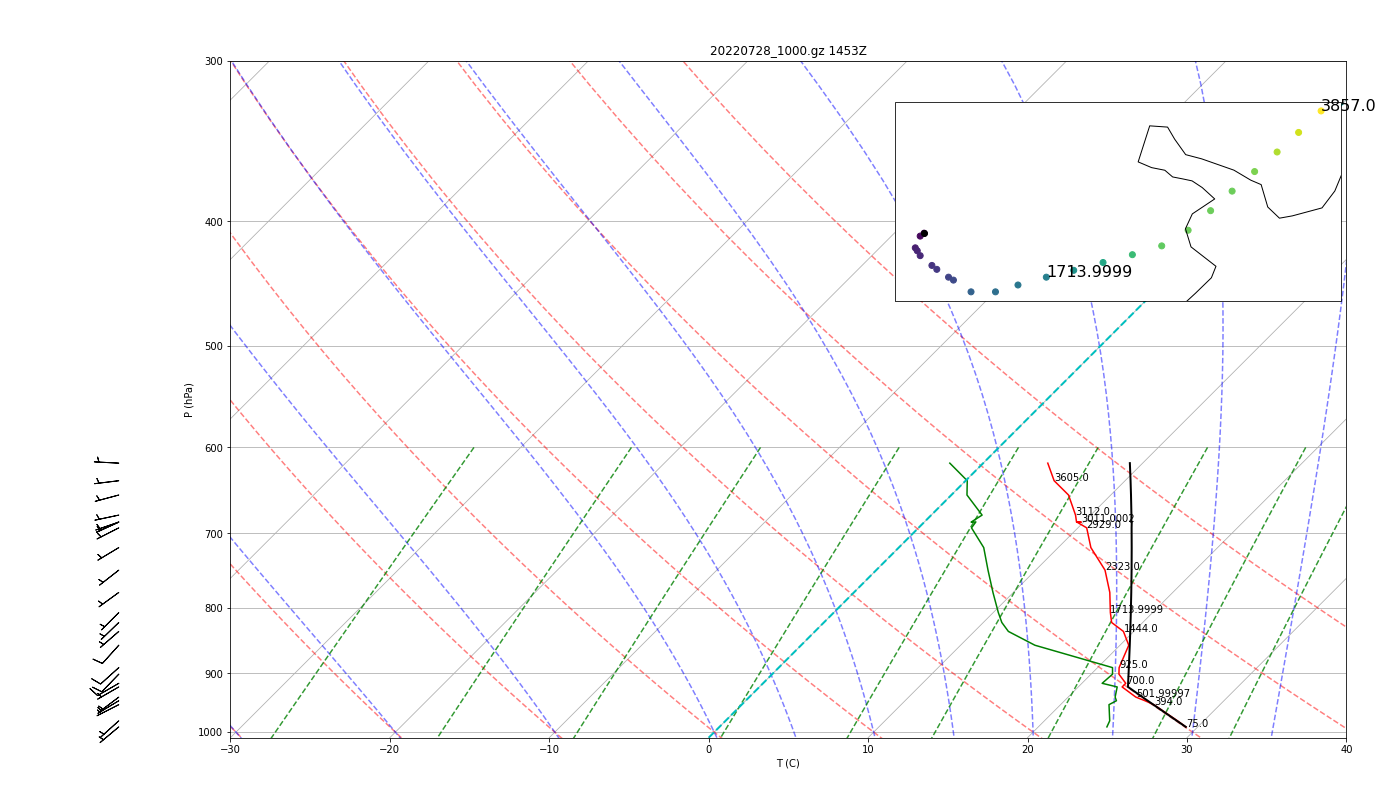

In [8]:
i=0
midway = []
for this_amdar in firstset:
    if this_amdar['airport'] == 'HOU':
        this_amdar['dset_file'] = datasets[-126]
        midway.append(this_amdar)
        i+=1
        print('Winner', i)

n = 0
metpy.plots.SkewT
fig=plt.figure(figsize=[20, 15])

skew = plots.SkewT(fig, rotation=45)
p = midway[n]['p']
p = p * units.hPa
T = midway[n]['T']  # pymeteo.thermo.T( midway[n]['th'], midway[n]['p'])
T = T-273.15
T = T * units.degC
Td = pymeteo.thermo.Td( midway[n]['p'], midway[n]['qv'])
Td = Td-273.15
Td = Td * units.degC
u =  midway[n]['u']
v =  midway[n]['v']
print(p.shape)
print(T.shape)
print(Td.shape)
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

# Sort the pressure array
p_sorted = sorted(p.magnitude, reverse=True) * units.Pa

# calculate and plot the parcel profile
parcel_prof = mpcalc.parcel_profile(p_sorted, T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

skew.plot(p/100.0, T, 'r')
skew.plot(p/100.0, Td, 'g')
skew.plot_barbs(p/100.0, u, v, xloc=-0.1)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.plot(p/100.0, parcel_prof, 'k', linewidth=2)

skew.shade_cape(p, T, parcel_prof)
skew.shade_cin(p, T, parcel_prof, Td)
plt.xlabel('T (C)')
plt.ylabel('P (hPa)')
plt.title(midway[n]['dset_file'] + ' ' + midway[n]['time'])

decimate = 2

for pp, tt, hh in zip(p[::decimate], T[::decimate], midway[n]['z'][::decimate]):
    skew.ax.text(tt, pp/100.0, hh)

plt.ylim([1010,300])
plt.xlim([-30.,40.])

axins = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
mp = axins.scatter(midway[n]['lon'], midway[n]['lat'], c=midway[n]['z'])
axins.add_feature(cartopy.feature.LAKES, zorder=0)
axins.add_feature(cartopy.feature.STATES)
plt.plot(midway[n]['lon'][0], midway[n]['lat'][0], 'ko')
half = int(len(midway[n]['lon'])/2.)

plt.text(midway[n]['lon'][-1], midway[n]['lat'][-1], str(midway[n]['z'][-1]), fontsize=16)
plt.text(midway[n]['lon'][half], midway[n]['lat'][half], str(midway[n]['z'][half]), fontsize=16)

## ARM Upper Air Data from Site M1

Add username, token, and datastream from ARM. 

In [22]:
username = "#######"
token =  "#######"
datastream = "housondewnpnM1.b1"
startdate = "2022-07-28"
enddate = "2022-07-28"

In [23]:
dataset = act.discovery.download_data(username = username,
                                 token = token,
                                 datastream = datastream,
                                 startdate = startdate,
                                 enddate = enddate, 
                                 )
dataset

[DOWNLOADING] housondewnpnM1.b1.20220728.112900.cdf
[DOWNLOADING] housondewnpnM1.b1.20220728.173000.cdf
[DOWNLOADING] housondewnpnM1.b1.20220728.052800.cdf
[DOWNLOADING] housondewnpnM1.b1.20220728.190600.cdf
[DOWNLOADING] housondewnpnM1.b1.20220728.205700.cdf
[DOWNLOADING] housondewnpnM1.b1.20220728.233100.cdf


['C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.112900.cdf',
 'C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.173000.cdf',
 'C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.052800.cdf',
 'C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.190600.cdf',
 'C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.205700.cdf',
 'C:\\Users\\Owner\\mattconda\\tracer-plotting\\housondewnpnM1.b1\\housondewnpnM1.b1.20220728.233100.cdf']

In [37]:
ds = act.io.read_netcdf(dataset[1])

print(ds.keys())
ts = ds['base_time'].values
p = ds['pres'].values * units.hPa
T = ds['tdry'].values * units.degC
Td = ds['dp'].values * units.degC
print(p.shape)
print(T.shape)
print(Td.shape)
wind_speed = ds['wspd'].values * units.knots
wind_dir = ds['deg'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

KeysView(<xarray.Dataset>
Dimensions:      (time: 5015)
Coordinates:
  * time         (time) datetime64[ns] 2022-07-28T17:30:00 ... 2022-07-28T18:...
Data variables: (12/24)
    base_time    datetime64[ns] 2022-07-28
    time_offset  (time) datetime64[ns] 2022-07-28T17:30:00 ... 2022-07-28T18:...
    pres         (time) float32 dask.array<chunksize=(5015,), meta=np.ndarray>
    qc_pres      (time) int32 dask.array<chunksize=(5015,), meta=np.ndarray>
    tdry         (time) float32 dask.array<chunksize=(5015,), meta=np.ndarray>
    qc_tdry      (time) int32 dask.array<chunksize=(5015,), meta=np.ndarray>
    ...           ...
    wstat        (time) float32 dask.array<chunksize=(5015,), meta=np.ndarray>
    asc          (time) float32 dask.array<chunksize=(5015,), meta=np.ndarray>
    qc_asc       (time) int32 dask.array<chunksize=(5015,), meta=np.ndarray>
    lat          (time) float32 dask.array<chunksize=(5015,), meta=np.ndarray>
    lon          (time) float32 dask.array<chunksize=(

In [38]:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

970.2779648524242 hectopascal 24.87032231984125 degree_Celsius


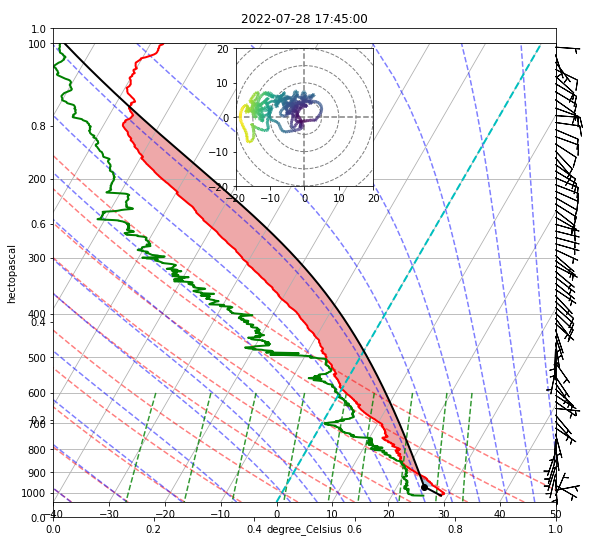

In [39]:
fig = plt.figure(figsize=(9, 9))
plt.title("2022-07-28 17:45:00")
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
mask = p>= 100 * units.hPa
skew.plot_barbs(p[mask][::50], u[mask][::50], v[mask][::50])
#shaded regions
skew.shade_cape(p, T, parcel_prof)
skew.shade_cin(p, T, parcel_prof, Td)
#Lines
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
#solid balck line
skew.plot(p, prof, 'k', linewidth=2)
#Red hashed lines
skew.plot_dry_adiabats()
#Blue hashed lines
skew.plot_moist_adiabats()
#Green hashed lines
skew.plot_mixing_lines()
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=-2)
h = Hodograph(ax_hod, component_range=20.)
h.add_grid(increment=5)
h.plot_colormapped(u, v, wind_speed)  

#axins = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right", 
                   #axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   #axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
#mp = axins.scatter(midway[n]['lon'], midway[n]['lat'], c=midway[n]['z'])
#axins.add_feature(cartopy.feature.LAKES, zorder=0)
#axins.add_feature(cartopy.feature.STATES)
#plt.plot(midway[n]['lon'][0], midway[n]['lat'][0], 'ko')
#half = int(len(midway[n]['lon'])/2.)
plt.show()
fig.savefig('Poster graphs/skewt0602173000M1SITE.png')

## NEXRAD Radar

In [14]:
aws_nexrad_level2_file = "s3://noaa-nexrad-level2/2022/07/28/KHGX/KHGX20220728_183424_V06"
radar = pyart.io.read_nexrad_archive(aws_nexrad_level2_file)
list(radar.fields)

['spectrum_width',
 'velocity',
 'differential_reflectivity',
 'reflectivity',
 'cross_correlation_ratio',
 'clutter_filter_power_removed',
 'differential_phase']

C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right

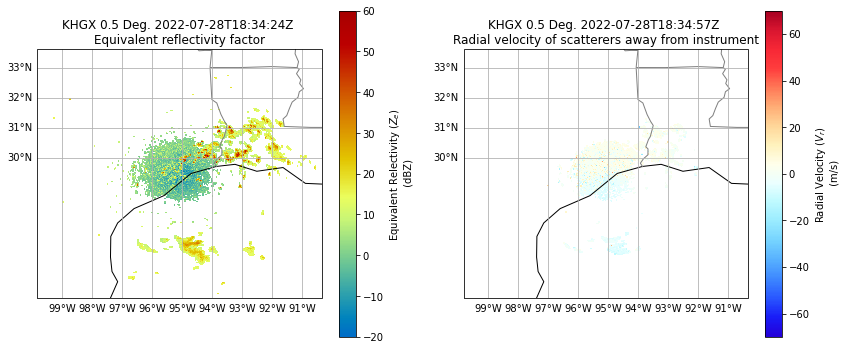

In [15]:
fig = plt.figure(figsize=(14,6))
display = pyart.graph.RadarMapDisplay(radar)

ax = plt.subplot(121,
                 projection=ccrs.PlateCarree())

display.plot_ppi_map('reflectivity',
                     sweep=0,
                     ax=ax,
                     colorbar_label='Equivalent Relectivity ($Z_{e}$) \n (dBZ)',
                     vmin=-20,
                     vmax=60)
fig.savefig('Poster graphs/reflectivity.png')
ax = plt.subplot(122,
                 projection=ccrs.PlateCarree())

display.plot_ppi_map('velocity',
                     sweep=1,
                     ax=ax,
                     colorbar_label='Radial Velocity ($V_{r}$) \n (m/s)',
                     vmin=-70,
                     vmax=70)
fig.savefig('Poster graphs/RadarReflectivity.png')

## ARM Vertical Radar

Add username, token, and datastream from ARM. 

In [16]:
username = "#######"
token =  "#######"
datastream = "houkazrcfrgeM1.a1"
startdate = "2022-07-28"
enddate = "2022-07-28"

In [17]:
rd = act.discovery.download_data(username = username,
                                 token = token,
                                 datastream = datastream,
                                 startdate = startdate,
                                 enddate = enddate, 
                                 )

[DOWNLOADING] houkazrcfrgeM1.a1.20220728.140003.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.000000.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.030004.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.015958.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.050001.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.060003.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.080001.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.110002.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.120002.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.010002.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.070003.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.100000.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.165959.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.160003.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.040000.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.090003.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.130004.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.150001.nc
[DOWNLOADING] houkazrcfrgeM1.a1.20220728.190004.nc
[DOWNLOADING] houkazrcfrgeM1.a1

In [18]:
radar = pyart.io.read(rd[18])
radar2 = pyart.io.read(rd[18])
radar.fields.keys()

dict_keys(['linear_depolarization_ratio', 'mean_doppler_velocity', 'mean_doppler_velocity_crosspolar_v', 'reflectivity', 'reflectivity_crosspolar_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_crosspolar_v', 'spectral_width', 'spectral_width_crosspolar_v'])

C:\Users\Owner\mattconda\envs\tracer-plotting-dev\lib\site-packages\pyart\graph\radarmapdisplay_basemap.py:78: DeprecationWarning: RadarMapDisplayBasemap is deprecated in favor of RadarMapDisplay. Basemap is still optional to use, but there will be no support if an error appears.
  warnings.warn("RadarMapDisplayBasemap is deprecated in favor of "


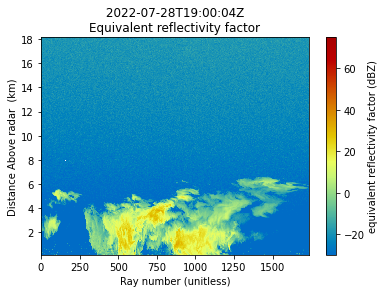

In [19]:
display = pyart.graph.RadarMapDisplayBasemap(radar)
display.plot_vpt('reflectivity')
#fig.savefig('Poster graphs/RadarReflectivity.png')

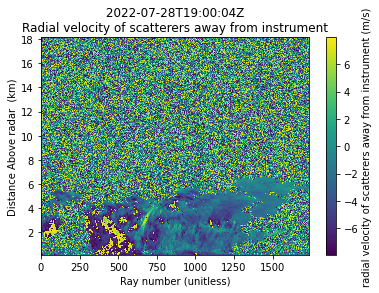

In [20]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_vpt('mean_doppler_velocity')
#fig.savefig('Poster graphs/RadarVelocity.png')

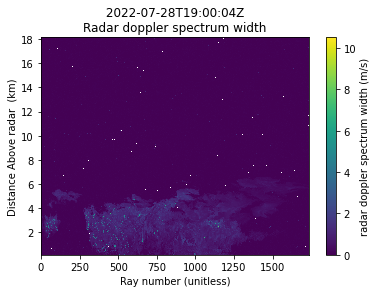

In [21]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_vpt('spectral_width')
#fig.savefig('Poster graphs/RadarSpectral.png')